<a href="https://colab.research.google.com/github/andygoosh/samsung/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [243]:
from pathlib import Path
from google.colab import files, drive
from collections import defaultdict

import re
import random as rn
import pandas as pd
import numpy as np
from numpy import array, argmax, random, take
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector, TimeDistributed
from keras import optimizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

RS = 77
rn.seed(RS)
# tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

gpath = Path('/content/gdrive')
drive.mount(str(gpath))
data_file = gpath / 'My Drive/Samsung' / 'transcriptions'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Let's look at the data in given file

In [23]:
with data_file.open() as f:  
    print(list(f.readline()))

['а', 'у', 'к', 'ц', 'и', 'о', 'н', 'ы', ' ', 'н', 'а', ' ', 'д', 'е', 'ш', 'ё', 'в', 'о', 'е', ' ', 'ж', 'и', 'л', 'ь', 'ё', ' ', 'п', 'р', 'о', 'в', 'о', 'д', 'я', 'т', 'с', 'я', ' ', 'р', 'е', 'г', 'у', 'л', 'я', 'р', 'н', 'о', '\t', '%', '%', ' ', 'a', ' ', 'u', ' ', 'k', ' ', 't', 's', ' ', 'y', ' ', 'o', '1', ' ', 'n', ' ', 'a', 'x', ' ', '#', ' ', 'n', ' ', 'a', 'x', "'", ' ', '_', ' ', 'd', "'", ' ', "'", 'i', ' ', 's', 'h', ' ', 'o', '1', ' ', 'v', ' ', 'a', 'x', "'", ' ', 'j', 'a', 'x', ' ', '#', ' ', 'z', 'h', ' ', 'y', "'", ' ', 'l', "'", ' ', 'j', "'", ' ', "'", 'o', '1', ' ', '#', ' ', 'p', ' ', 'r', ' ', 'a', ' ', 'v', ' ', 'o', "'", '1', ' ', 'd', "'", ' ', "'", 'a', 'x', ' ', 't', 's', ' ', 't', 's', ' ', 'a', 'x', "'", ' ', '#', ' ', 'r', "'", ' ', "'", 'i', 'x', ' ', 'g', ' ', 'u', "'", ' ', 'l', "'", ' ', "'", 'a', '1', ' ', 'r', ' ', 'n', ' ', 'a', ' ', '%', '%', '\n']


#### Notice that:
1. russian sentence is separated from transcript with '\t'
2. the begining and the end of transcript part are marked by '%%'

### Let's read the data and split it into rus and trans

In [4]:
rus_trn = []
with data_file.open() as f:  
  for line in f: 
    rus, trn = line.split('\t')
    rus_trn.append([rus.strip(), trn.strip()])

print(f'Number of sentences in corpus: {len(rus_trn)}')

Number of sentences in corpus: 50277


##### Let's look at some sentences


In [25]:
print(rus_trn[13][0])
print(rus_trn[13][1])
print(rus_trn[24][0])
print(rus_trn[24][1])


устрицы подают с простыми винами типа рислинга
%% u1 s t r' 'ix ts ax # p ax d a' j' 'u1 t # s _ p r a s t y'1 m' 'ix' # v' 'i1 n ax' m' 'ix' # t' 'i1 p ax' # r' 'i1 s l' 'ix n g a %%
отношение числа городских и сельских жителей четыре к одному
%% a t n a sh e'1 n' 'ix' jax' # ch' 'i s l a1 # g ax r a ts k' 'i1 h # y' _ s' 'e'1 l' s k' 'ix gh # zh y'1 t' 'ix' l' 'ix' j' %% %% ch' 'i t y'1 r' 'ix # k _ ax d n a m u1 %%


#### Notice that words in russian sentence are separated by space while words in transcript are separated:
1. by '#' in general case
2. by '_' in case of preposition
3. by '%% %%' in case of punctuation signs (dash, coma, etc)


#### Let's see if we have dupliates in corpus

In [26]:
a = array(rus_trn)
seen_rus = Counter(a[:,0])
seen_trn = Counter(a[:,1])

print(f'Unique rus sentences: {len(seen_rus)} out of {len(rus_trn)}')
print(f'Unique trans sentences: {len(seen_trn)} out of {len(rus_trn)}')

Unique rus sentences: 3131 out of 50277
Unique trans sentences: 3171 out of 50277


#### We have a lot of duplicates! Only 3131 unique sentenses out of 50K in corpus. Please also note that some russian sentences are transcribed into different transcriptions (will look into that later on)

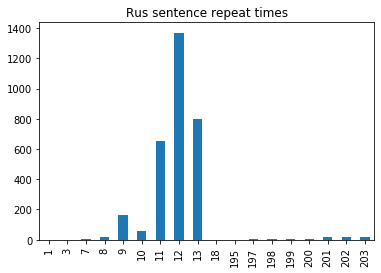

In [27]:
lens = [each[1] for each in seen_rus.items()]
unq = np.unique(lens)
qty = [lens.count(each) for each in unq]
pd.DataFrame(qty, index=unq).plot.bar(title = 'Rus sentence repeat times', legend=False);

#### Most duplicated sentences repeat 12 times, max up to 203 times

### Let's read that data while splitting the words. We'll count the words in each sentence. If the count in rus and trans is different, we'll record it as anomaly


Anomalies: 49


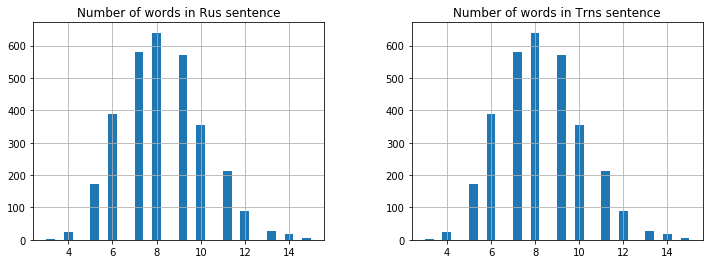

In [5]:
rus_l, trn_l, anomaly = [], [], []
seen = defaultdict(list)
chars = Counter()

for j,i in enumerate(rus_trn):
  rus = i[0].split()
  trn = re.split('#|_|%% %%',i[1])

  if i[0] not in seen:
    if abs(len(rus) - len(trn)) != 0: 
      anomaly.append(j)
    else:
      rus_l.append(len(rus))
      trn_l.append(len(trn))

    chars += Counter(i[0])  

  seen[i[0]].append(j)

print(f'Anomalies: {len(anomaly)}')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

#### So we have 49 anomalies out of 3131 samples

### Let's see if we need to clean the data. First let's take a look at rus corpus alphabet

Number of times "-" used: 159


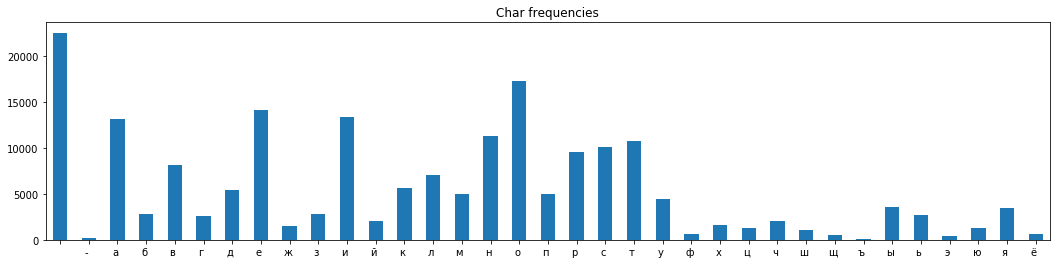

In [29]:
s = sorted(chars.items())
pd.DataFrame(s, index=(e[0]+' ' for e in s)).plot.bar(figsize=(18,4), rot=0, title = 'Char frequencies', legend=False)
print(f'Number of times "-" used: {chars["-"]}')

#### Looks good! We neither have punctuations nor capital letters. The only case to check is '-' letter which is used 159 times

In [4]:
seen = set()
seen_dash = set()
dash_words = []
for rus,trn in rus_trn:
  if rus not in seen:
    if '-' in rus:
      ru_words = rus.split()
      for each in ru_words:
        if '-' in each:
          if each not in seen_dash:
            seen_dash.add(each)
            dash_words.append(each)
  else:
    seen.add(rus)
  
print(dash_words)

['анти-обледенитель', 'иридо-диагностика', 'дом-красавец', 'из-за', 'радио-сигналом', 'ноль-три', 'ноль-два', 'мало-обеспеченные', 'шкаф-купе', 'тех-осмотр', 'пресс-службе', 'авто-сервис', 'чуть-чуть', 'аудио-', 'какие-либо', 'де-факто', 'стерео-', 'царь-колокол', 'царь-пушка', 'гео-магнитного', 'электро-катастрофы', 'фигуристы-новобранцы', 'что-то', 'какое-либо', 'веб-операторы', 'воздушно-десантной', 'военно-морских', 'ветераны-афганцы', 'одного-единственного', 'природно-климатические', 'одном-двух', 'санкт-петербурге', 'стран-участниц', 'пять-шесть', 'по-своему', 'матч-реванш', 'словаря-справочника', 'штаб-квартире', 'чем-то', 'чего-то', 'экс-губернатора', 'российско-американский', 'северо-восточных', 'красно-белую', 'какой-нибудь', 'бело-жёлтый', 'карту-схему', 'юго-западный', 'радио-охранное', 'по-прежнему', 'каким-то', 'кино-картины', 'авто-трюки', 'пресс-конференции', 'генерал-прокурором', 'нью-йорке', 'медиа-группы', 'нью-йоркской', 'какие-то', 'санкт-петербурга', 'санкт-петерб

#### Okey, words with dash look fine, we'll consider dash as a normal letter

### So in order to implement autocoder for transcript we'd need to keep special symbools in transcript such as "\_" and "%% %%". So let's create a dictionary of sentences rus <-> trans. So let's recreate the dictionary so "\_" and "%% %%" are marked with '#' and remove begin and end markers. Plus to that let's get rid of duplicates.


In [141]:
!pip3 install transliterate

     |████████████████████████████████| 51kB 1.8MB/s 


In [142]:
from transliterate import translit
translit('длавды дылпадыал лыдап', 'ru', reversed=True)

'dlavdy dylpadyal lydap'

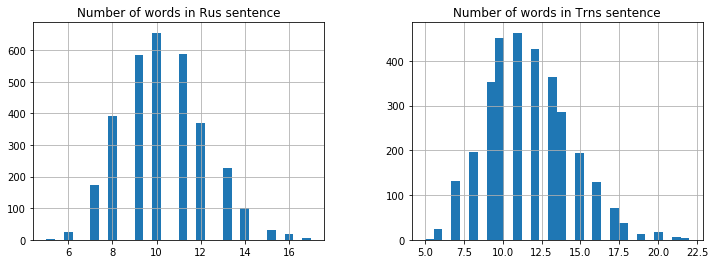

In [193]:
seen_rus = set()
seen_trn = set()

res, trn_l, rus_l = [], [], []

for rus, trn in rus_trn:

  if rus not in seen_rus or trn not in seen_trn:
      seen_rus.add(rus)
      seen_trn.add(trn)

      trn = trn.replace('%% %%', '#%% %%#').replace('_', '#_#')[2:-2]
      # trn = trn[2:-2]
      # trn = translit(rus, 'ru', reversed=True)

      rus = '<start> ' + rus + ' <end>'
      trn = '<start>#' + trn + '#<end>'


      res.append([rus, trn])

      rus_l.append( len(rus.split()))
      trn_l.append( len(trn.split('#')))
      # if len(trn.split('#')) > 17:
      #   print(rus)
      #   print(trn)

rus_trn_new = array(res)
trn_length = max(trn_l)
rus_length = max(rus_l)
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

In [0]:
# trn = re.split(r'#|(_|%% %%)',rus_trn[0][1][2:-2])
# trn = list(filter(None, trn))
# '#'.join(trn)

### Text to Sequence Conversion

In [194]:
for rus, trn in rus_trn_new:
  # if rus == 'стоимость и ценность пропажи уточняются':
  if 'здание аргентинского посольства расположено крайне неудачно' in rus:
    print(trn)

<start># z d a'1 n' 'ix' jax # a r g' 'i' n' t' 'i1 n s k ax v ax # p a s o'1 l' s t v ax # r ax s p a l o1 zh ax n ax # k r a'1 j' n' 'ix' # n' 'ixu d a'1 ch' n a #<end>


In [0]:
def tokenization(lines, split=' '):
  tokenizer = Tokenizer(filters='', lower=False, split=split)
  tokenizer.fit_on_texts(lines)
  return tokenizer

def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(sequences=seq, maxlen=length, padding='post')
  return seq

In [196]:
rus_tokenizer = tokenization(rus_trn_new[:, 0])
rus_vocab_size = len(rus_tokenizer.word_index) + 1
trn_tokenizer = tokenization(rus_trn_new[:, 1], split='#')

trn_vocab_size = len(trn_tokenizer.word_index) + 1
print(f'Rus Vocabulary Size: {rus_vocab_size}')
print(f'Trns Vocabulary Size: {trn_vocab_size}')

Rus Vocabulary Size: 12178
Trns Vocabulary Size: 13722


### German


In [22]:
import string

# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t')[:2] for i in sents]
      return sents

data = read_text(gpath / 'My Drive/Samsung' / 'deu.txt')
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

deu_eng = deu_eng[:50000,:]

# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['he has no specific aim', 'er hat kein bestimmtes ziel'],
       ['he has only four pesos', 'er hat nur vier pesos'],
       ['he has stopped smoking', 'er hörte mit dem rauchen auf']],
      dtype='<U537')

In [157]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 15
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
model.summary()

# train model
history = model.fit(trainX, trainY.reshape(*trainY.shape, 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[], 
                    verbose=1)

English Vocabulary Size: 12176
Deutch Vocabulary Size: 12166
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 15, 512)           6228992   
_________________________________________________________________
lstm_37 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
repeat_vector_19 (RepeatVect (None, 8, 512)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 8, 512)            2099200   
_________________________________________________________________
dense_19 (Dense)             (None, 8, 12176)          6246288   
Total params: 16,673,680
Trainable params: 16,673,680
Non-trainable params: 0
_________________________________________________________________
Train on 2029 samples, validate on 508 samples

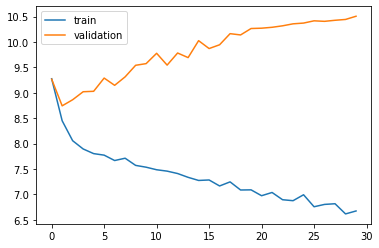

In [158]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [48]:
preds = model.predict_classes(testX[:100])
preds

preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

pred_df = pd.DataFrame({'actual' : test[:100,0], 'predicted' : preds_text})
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
96,is that a yes or a no,is that a yes
35,tom heated the milk,tom spilled the horse
67,youre still shaking,youre look still
74,even tom laughed,even tom
24,the lights went out,the students went out
46,sit down please,please sit a
97,tom left a message,tom has a great
16,why wont tom help us,why cant tom help
62,he is a clever boy,hes a boy
75,were still young,were still young


### Model Building


In [197]:
rus_trn_new.shape

(3172, 2)

In [0]:
train, test = train_test_split(rus_trn_new, test_size=0.2, random_state = RS)

# prepare training data
trainX = encode_sequences(rus_tokenizer, rus_length, train[:, 0])
trainY = encode_sequences(trn_tokenizer, trn_length, train[:, 1])

# prepare validation data
testX = encode_sequences(rus_tokenizer, rus_length, test[:, 0])
testY = encode_sequences(trn_tokenizer, trn_length, test[:, 1])

In [267]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print(f'{t} ----> {lang.index_word[t]}')

print ("Input Language; index to word mapping")
convert(rus_tokenizer, trainX[-5])
print ()
print ("Target Language; index to word mapping")
convert(trn_tokenizer, trainY[-5])

Input Language; index to word mapping
1 ----> <start>
38 ----> после
7489 ----> травмы
7490 ----> нос
23 ----> может
2735 ----> приобрести
7491 ----> седловидную
2736 ----> форму
2 ----> <end>

Target Language; index to word mapping
2 ----> <start>
55 ---->  p o1 s l' 'ix 
8107 ---->  t r a1 v m ax 
8108 ---->  n o1 s 
38 ---->  m o1 zh ax t 
8109 ---->  p r' 'ixa b r' 'i' s' t' 'i'1 
8110 ---->  s' 'ix d l a' v' 'i1 d n ux' jux 
8111 ---->  f o1 r m u 
3 ----> <end>


In [200]:
trainX.shape, trainY.shape

((2854, 17), (2854, 22))

In [201]:
testX.shape, testY.shape

((318, 17), (318, 22))

In [262]:
# build NMT model
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

model = define_model(rus_vocab_size, trn_vocab_size, rus_length, trn_length, 512)
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 17, 512)           6235136   
_________________________________________________________________
lstm_56 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
repeat_vector_28 (RepeatVect (None, 22, 512)           0         
_________________________________________________________________
lstm_57 (LSTM)               (None, 22, 512)           2099200   
_________________________________________________________________
dense_27 (Dense)             (None, 22, 13722)         7039386   
Total params: 17,472,922
Trainable params: 17,472,922
Non-trainable params: 0
_________________________________________________________________


In [269]:
# optimizer = optimizers.RMSprop(lr=0.001)
optimizer=optimizers.Adam()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

monitor = 'val_loss'
mode = 'min'
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor=monitor, verbose=1, save_best_only=True, mode=mode)
early_stop = EarlyStopping( patience=25, monitor=monitor, mode=mode)

# train model
history = model.fit(trainX, trainY.reshape(*trainY.shape, 1),
                    validation_data=(testX, testY.reshape(*testY.shape, 1)),
                    # validation_split = 0.2,
                    epochs=100, batch_size=512, callbacks=[early_stop], 
                    verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Train on 2537 samples, validate on 635 samples
Epoch 1/100
2537/2537 [==============================] - 17s 7ms/step - loss: 5.8133 - val_loss: 5.9592
Epoch 2/100
2537/2537 [==============================] - 3s 1ms/step - loss: 5.8108 - val_loss: 5.9570
Epoch 3/100
2048/2537 [=======================>......] - ETA: 0s - loss: 5.8111

KeyboardInterrupt: ignored

In [266]:
# model = load_model('model.h5')
preds = model.predict_classes(testX)
preds[0], testY[0]

(array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([   2, 7729, 7730, 7731, 7732, 7733,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       dtype=int32))

In [221]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == n:
          return word
  return None
  
t = []
for e in testX[0]:
  s = get_word(e, rus_tokenizer)
  if s: t.append(s)
print( ' '.join(t) )

t = []
for e in testY[0]:
  s = get_word(e, trn_tokenizer)
  if s: t.append(s)
print( '#'.join(t) )

<start> космический аппарат передал сенсационные снимки <end>
<start># k a s m' 'i'1 ch' 'ix s k' 'ix' j' # 'a p a r a1 t # p' 'ix' r' 'i d a1 l # s' 'ix n s ax ts y o1 n n ax' jax' # s' n' 'i1 m k' 'i #<end>


In [258]:
preds_text = []
prd = preds[:3]
for i in prd:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], trn_tokenizer)
    if j > 0:
      if (t == get_word(i[j-1], trn_tokenizer)) or (t == None):
        temp.append('')
      else:
        temp.append(t+'#')
    else:
      if(t == None):
            temp.append('')
      else:
              temp.append(t+'#') 

  preds_text.append(''.join(temp))

def unpack(tensor):
  t = []
  for e in tensor:
    s = get_word(e, rus_tokenizer)
    if s: t.append(s)
  return ' '.join(t)

preds_text
# print( list(zip((unpack(e) for e in testX[:3]), preds_text)))
# pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
# pred_df.sample(15)

['<start>#_#<end>#', '<start>#_#<end>#', '<start>#_#<end>#']